In [23]:
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gmean
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from doe_modules.preferences import harmonic_mean
from doe_modules.preferences import kwarg_savefig, outputdir, harmonic_mean
from doe_modules.ml import plot_pr, plot_roc
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score
from sklearn.linear_model import LogisticRegression

from doe_modules.simulation.esm4_metrics import (
    cai, edge_coverage, pathway_coverage, max_positive_edge_density,
    max_synergetic_edge_density
)

In [42]:
from doe_modules.preferences import harmonic_mean

def cai2(arr):
    return harmonic_mean(
        edge_coverage(arr),
        1 - pathway_coverage(arr),
        max_positive_edge_density(arr),
        max_synergetic_edge_density(arr)
    )

In [43]:
edges = np.array(list(map(list, product([-1, 0, 1], repeat=10))))

df = pd.read_feather(
    f"{outputdir}/esm_test4.feather"
).assign(
    edge_coverage=pd.DataFrame({
        "edge_coverage": map(edge_coverage, edges),
    })
).assign(
    pathway_sparsity=pd.DataFrame({
        "pathway_sparsity": map(lambda x: 1 - pathway_coverage(x), edges),
    })
).assign(
    max_positive_edge_density=pd.DataFrame({
        "max_positive_edge_density": map(max_positive_edge_density, edges),
    })
).assign(
    max_synergetic_edge_density=pd.DataFrame({
        "max_synergetic_edge_density": map(lambda x: 1 - max_synergetic_edge_density(x), edges),
    })
).assign(
    cai=pd.DataFrame({
        "cai": map(cai, edges),
    })
)

df = df.assign(
    mean1=df.iloc[:, 4:7].mean(axis=1)
).assign(
    mean2=df.iloc[:, 6:8].mean(axis=1)
).assign(
    max1=df.iloc[:, 4:7].max(axis=1)
).assign(
    cai2=pd.DataFrame({
        "cai2": map(cai2, edges),
    })
)

df = df.assign(
    better_with_cloo=df.cloo >= df.pb
)

# df = df.iloc[np.where((edges[:, :4] == 0).sum(axis=1) != 4)]

from sklearn.metrics import confusion_matrix

def cai_performance(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return np.vectorize(lambda t: metric(data.cloo < data.pb, data.cai <= t))(xrange)

def cai_performance_plot(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return (xrange, cai_performance(data, metric, xrange))

def argmax_cai(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    y = cai_performance(data, metric, xrange)
    argmax = np.argmax(y)
    return (xrange[argmax], y[argmax])

In [14]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score, recall_score, precision_score

import warnings
warnings.simplefilter('ignore')

fig, ax = plt.subplots(figsize=(3, 3))

metrics = {
    # "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "F$_1$": f1_score,
    # "AUROC": roc_auc_score,
    # "AP": average_precision_score,
}

cmap = sns.color_palette("husl", len(metrics))

for  i, (k, metric) in enumerate(metrics.items()):
    x, y = cai_performance_plot(df, metric)
    ax.plot(x, y, color=cmap[i])
    idx = np.argmax(y)
    argmax_max = (x[idx], y[idx])
    ax.scatter(
        *argmax_max, 
        label=f"{k} ({argmax_max[1].round(3)})",
        color=cmap[i]
    )
    ax.vlines(*argmax_max, -0.05, color=cmap[i], linestyle="--", zorder=-100, alpha=.3)
    ax.text(argmax_max[0], .03, "$\leq$" + f"{argmax_max[0].round(2)}", color=cmap[i], ha="left", va="bottom")

ax.set_xlim(-.05, 1.05)
ax.set_ylim(-.05, 1.05)

ax.legend(loc="center left", bbox_to_anchor=(1, .5), fontsize="small")

ax.set_title("Decision thresholds for\nadopting PB designs (ESM4)", size="medium")
ax.set(xlabel="CAI", ylabel="scores")

fig.savefig(f"{outputdir}/decision_thresh_test4", **kwarg_savefig)

In [15]:
df

,cloo,pb,v,,edge_coverage,pathway_sparsity,max_positive_edge_density,cai,arithmetic,geometric,better_with_cloo
0,1.000000,1.000000,3,both,1.000000,0.0,0.00,0.0,0.333333,0.0,True
1,1.000000,1.000000,3,both,0.833333,0.0,0.00,0.0,0.277778,0.0,True
2,1.000000,1.000000,3,both,1.000000,0.0,0.00,0.0,0.333333,0.0,True
3,1.000000,1.000000,3,both,0.833333,0.0,0.00,0.0,0.277778,0.0,True
4,1.000000,1.000000,3,both,0.666667,0.0,0.00,0.0,0.222222,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...
59044,1.000000,1.000000,3,both,0.666667,0.0,0.75,0.0,0.472222,0.0,True
59045,1.000000,0.750000,1,C+LOO,0.833333,0.0,1.00,0.0,0.611111,0.0,True
59046,0.333333,-0.333333,0,neither,1.000000,0.0,0.50,0.0,0.500000,0.0,True
59047,0.750000,0.750000,3,both,0.833333,0.0,0.60,0.0,0.477778,0.0,True


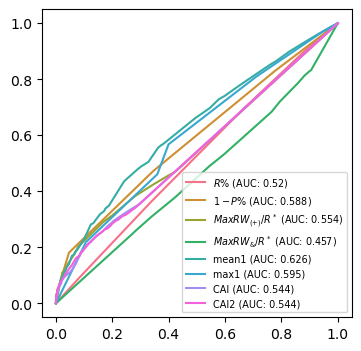

In [44]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    df.edge_coverage, df.pathway_sparsity, df.max_positive_edge_density,
    df.max_synergetic_edge_density,
    df.mean1, 
    # df.mean2, 
    df.max1,
    # df.geometric, 
    df.cai,
    df.cai2
]

names = [
    "$R\%$", "$1-P\%$", "$MaxRW_{(+)}/R^*$", 
    "$MaxRW_{&}/R^*$",
    "mean1", 
    # "mean2", 
    "max1",
    # "geometric", 
    "CAI",
    "CAI2",
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_cloo, y)[:2], 
        label=names[i] + f" (AUC: {roc_auc_score(df.better_with_cloo, y).round(3)})", 
        c=cmap[i]
    )

ax.legend(fontsize="x-small")

In [26]:
from sklearn.metrics import precision_recall_curve

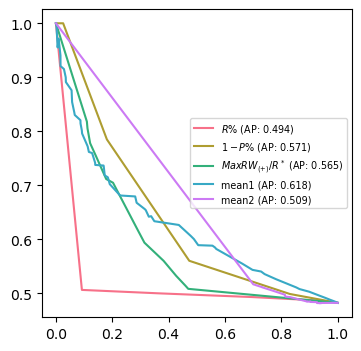

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))

features = [
    df.edge_coverage, df.pathway_sparsity, df.max_positive_edge_density,
    df.mean1, df.mean2,
    # df.geometric, df.cai
]

names = [
    "$R\%$", "$1-P\%$", "$MaxRW_{(+)}/R^*$", "mean1", "mean2",
    # "geometric", "CAI"
]


cmap = sns.color_palette("husl", len(features))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_cloo, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_cloo, y).round(3)})", 
        c=cmap[i]
    )

ax.plot(np.linspace(0, 1, 10), np.linspace(1, 1, 10), c=".7", alpha=0)

ax.legend(fontsize="x-small")